<a href="https://colab.research.google.com/github/Arnoldzyf/xQxJtfuuVcULmc7B/blob/main/1_happy_customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task

**Backgrounds:**    
A fast growing startups in the logistics and delivery domain needs to measure how satisfied each customer is based on their questionaire.

**Task Description**:
1. Predict if a customer is happy or not based on the answers they give to questions asked
  - Reach 73% accuracy score or above

2. what is the minimal set of attributes/features that would preserve the most information about the problem while increasing predictability of the data we have


**Task Analysis**:
1. Classification Problem ([sklearn](https://scikit-learn.org/stable/))
  - classification model
  - regression model + threshold
  - neural net
2. Feature Importance
  - test best model on validation set   
  - `feature_importances_` in sklearn `RandomForestClassifier`
  - ?? Other ways
    - delete iteratively (permutation)
    - dimension reduction (PCA, ...)
    - feature selection (coefficient, ...)
3. only need a very **small** model

**Solution Strategy:**
- Column Inspection: delete features that Y_avg stays level when X changes
- Use XGBoost
- Compute `feature_improtances_` from the model (by gini index / info gain)

In [2]:
import numpy as np
import pandas as pd

# Data Preprocessing

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers  
X1 = my order was delivered on time  
X2 = contents of my order was as I expected  
X3 = I ordered everything I wanted to order  
X4 = I paid a good price for my order  
X5 = I am satisfied with my courier  
X6 = the app makes ordering easy for me  

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

## Load the Data

In [3]:
path = "/content/drive/MyDrive/Apziva/Project 1 - Happy Customers/Resources/ACME-HappinessSurvey2020.csv"
survey_df = pd.read_csv(f"{path}")
survey_df

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5
...,...,...,...,...,...,...,...
121,1,5,2,3,4,4,3
122,1,5,2,3,4,2,5
123,1,5,3,3,4,4,5
124,0,4,3,3,4,4,5


Very small portion of data, be careful with overfitting

## Check Whether it's a Balanced Dataset

In [4]:
survey_df["Y"].value_counts(normalize=True)

1    0.547619
0    0.452381
Name: Y, dtype: float64

- Almost balanced

## Statistics

In [5]:
## Data Type and Missing Values
survey_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


- No missing values

In [6]:
survey_df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


- distribution of each column -- not needed now

In [7]:
corr = survey_df.corr(numeric_only = True)
corr.style.background_gradient(cmap='coolwarm')

,Y,X1,X2,X3,X4,X5,X6
Y,1.000000,0.280160,-0.024274,0.150838,0.064415,0.224522,0.167669
X1,0.280160,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873
X2,-0.024274,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205
X3,0.150838,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750
X4,0.064415,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888
X5,0.224522,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195
X6,0.167669,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000


- ? color

- data augmentation -- ususally in Image Process, not needed this time

## Split Data

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(survey_df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)
print(f"Training set has {len(train)} samples")
print(f"Validation set has {len(val)} samples")
print(f"Test set has {len(test)} samples")

Training set has 80 samples
Validation set has 20 samples
Test set has 26 samples


In [9]:
X_train = train.drop(columns=['Y'])
y_train = train['Y']

X_val = val.drop(columns=['Y'])
y_val = val['Y']

X_test = test.drop(columns=['Y'])
y_test = test['Y']

## Column Inspection

- ? only on the training set

In [10]:
import matplotlib.pyplot as plt

def show_avg_Y_and_observation(X,Y,X_value=[1, 2, 3, 4, 5], show_plot=True, use_X_frequency=True):
  """
  For each possible value of X:
    count its appearances, stored in X_num
    compute its corresponding mean Y, stored in Y_avg
  X, Y are dataframe columns
  """
  # print(X.value_counts())
  X_num = []
  X_freq = []
  Y_avg = []

  for x in X_value:
    num = (X == x).sum()
    X_num.append(num)
    freq = num / len(X)
    X_freq.append(freq)
    avg = Y[X==x].mean()
    Y_avg.append(avg)

  # print(X_num)
  # print(Y_avg)

  if show_plot:
    fig, ax1 = plt.subplots()

    # ax1.set_title('column inspection', fontsize=16)

    '''plot X Occurrences'''
    X_data = X_num
    color1='blue'

    if use_X_frequency:
      X_data = X_freq
      ax1.set_ylim(-0.05, 1.05)

    bar = ax1.bar(X_value, X_data, color=color1)
    ax1.bar_label(bar, padding=3, color=color1)

    ax1.set_xlabel('X Value')
    ax1.set_ylabel('X Occurrences', color=color1)
    ax1.tick_params(axis='y', color=color1)

    '''plot Y Average'''
    ax2 = ax1.twinx()  # share the x-axis, new y-axis
    color2 = 'red'

    ax2.plot(X_value, Y_avg, color=color2, marker="x")
    for i, j in zip(X_value, Y_avg):
      j = round(j, 4)
      plt.text(i-0.3, j+0.06, str(j), color=color2)

    ax2.set_ylabel('Average Y', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_ylim(-0.05, 1.05)

    plt.show()

  return {"Y_avg": Y_avg, "X_num": X_num, "X_freq": X_freq}

# show_avg_Y_and_observation(train['X1'], train['Y'])

**Below, on the training set, for each value of a feature X, we will use the frequency of the value and the average of Y (true label) to plot.**

**X1**

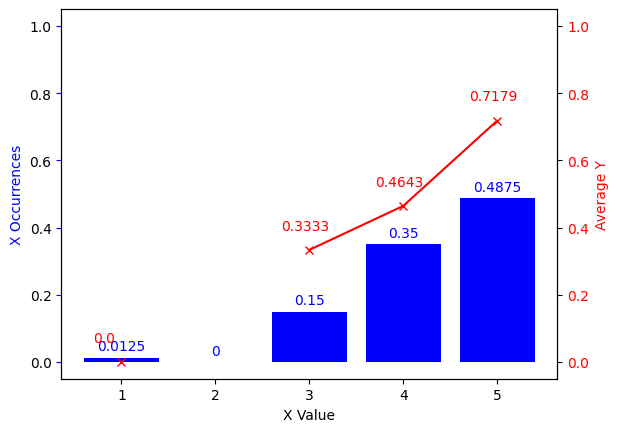

{'Y_avg': [0.0,
  nan,
  0.3333333333333333,
  0.4642857142857143,
  0.717948717948718],
 'X_num': [1, 0, 12, 28, 39],
 'X_freq': [0.0125, 0.0, 0.15, 0.35, 0.4875]}

In [11]:
show_avg_Y_and_observation(train['X1'], train['Y'])

**X2**

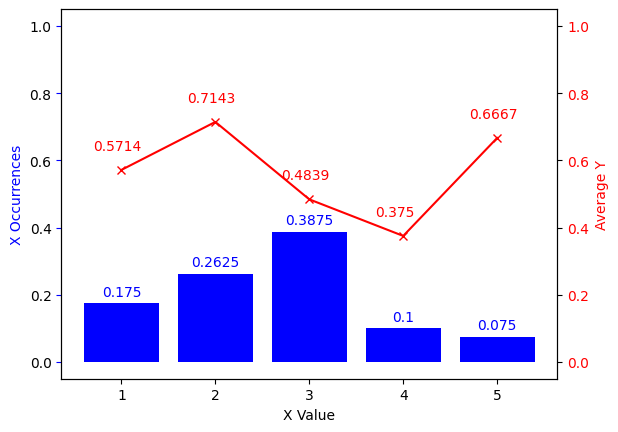

{'Y_avg': [0.5714285714285714,
  0.7142857142857143,
  0.4838709677419355,
  0.375,
  0.6666666666666666],
 'X_num': [14, 21, 31, 8, 6],
 'X_freq': [0.175, 0.2625, 0.3875, 0.1, 0.075]}

In [12]:
show_avg_Y_and_observation(train['X2'], train['Y'])

**X3**

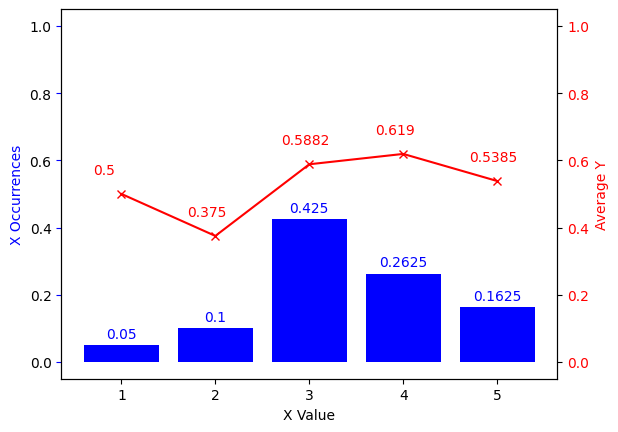

{'Y_avg': [0.5,
  0.375,
  0.5882352941176471,
  0.6190476190476191,
  0.5384615384615384],
 'X_num': [4, 8, 34, 21, 13],
 'X_freq': [0.05, 0.1, 0.425, 0.2625, 0.1625]}

In [13]:
show_avg_Y_and_observation(train['X3'], train['Y'])

**X4**

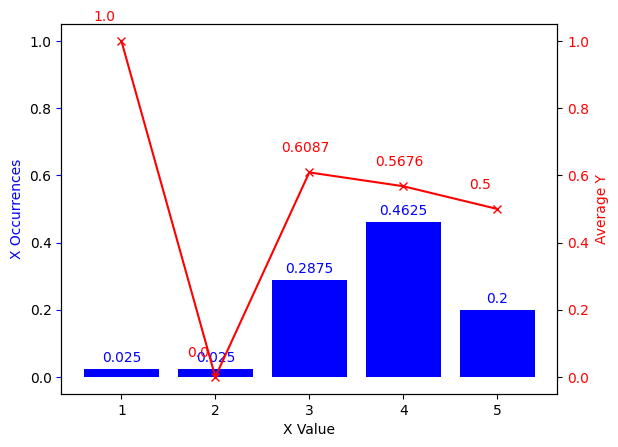

{'Y_avg': [1.0, 0.0, 0.6086956521739131, 0.5675675675675675, 0.5],
 'X_num': [2, 2, 23, 37, 16],
 'X_freq': [0.025, 0.025, 0.2875, 0.4625, 0.2]}

In [14]:
show_avg_Y_and_observation(train['X4'], train['Y'])

**X5**

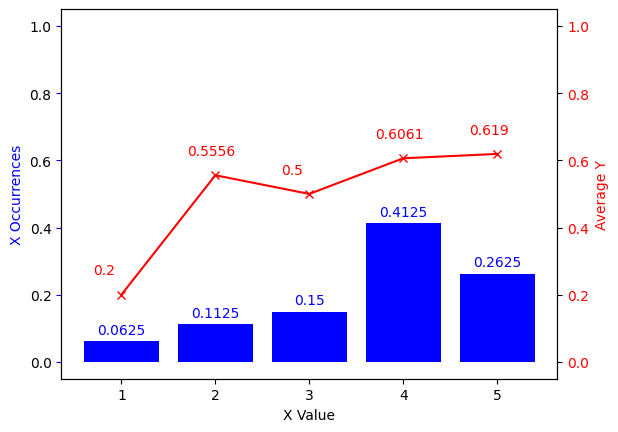

{'Y_avg': [0.2,
  0.5555555555555556,
  0.5,
  0.6060606060606061,
  0.6190476190476191],
 'X_num': [5, 9, 12, 33, 21],
 'X_freq': [0.0625, 0.1125, 0.15, 0.4125, 0.2625]}

In [15]:
show_avg_Y_and_observation(train['X5'], train['Y'])

**X6**

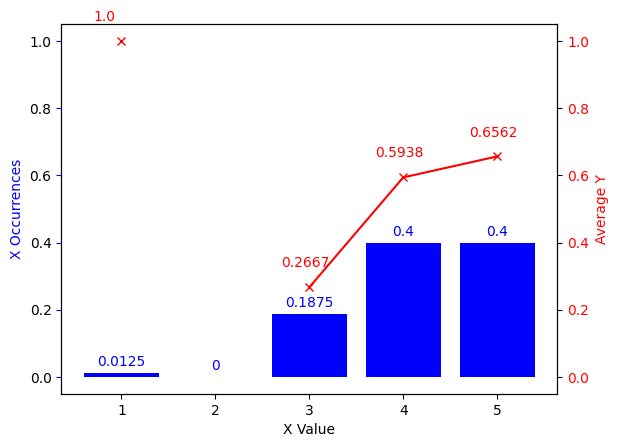

{'Y_avg': [1.0, nan, 0.26666666666666666, 0.59375, 0.65625],
 'X_num': [1, 0, 15, 32, 32],
 'X_freq': [0.0125, 0.0, 0.1875, 0.4, 0.4]}

In [16]:
show_avg_Y_and_observation(train['X6'], train['Y'])

- Probably due the small amount of data, there's no obvious sign where the change of which feature won't influence the aerage of the true Y value
- ? Maybe X2 can be deleted

## ~Standardize Data~

Not needed here, as X1~X5 are well-structured in this case.

In [17]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler().fit(X_train_un)

In [18]:
# X_train = scaler.transform(X_train_un)  ## zero mean, unit variance
# print(X_train.mean(axis=0))
# print(X_train.std(axis=0))

In [19]:
# X_val = scaler.transform(X_val_un)
# X_test = scaler.transform(X_test_un)

# print(X_val.mean(axis=0))
# print(X_val.std(axis=0))
# print(X_test.mean(axis=0))
# print(X_test.std(axis=0))

Not close to 0 and 1 --> The performance of `StandardScaler()` is **NOT** good.    
Maybe it's casued by the small data size, i.e. the distribution of training data cannot well represent the distribution of all the data.

In [20]:
## no need to change Y
# y_train, y_val, y_test = y_train_un, y_val_un, y_test_un

# XGBoost

## Train

- ! Havn't took a look at its math detail
  - [a post might be usefull](https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5)
- Not sure about the params
- Doc: use [xgboost with sklearn](https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html)

In [21]:
import xgboost as xgb

clf_XGB = xgb.XGBClassifier(tree_method="hist", n_estimators = 50, early_stopping_rounds=5)
clf_XGB = clf_XGB.fit(X_train, y_train, eval_set=[(X_val, y_val)])
print(f"training accuracy: {clf_XGB.score(X_train, y_train)}")

print(f"validation accuracy: {clf_XGB.score(X_val, y_val)}")

[0]	validation_0-logloss:0.64747
[1]	validation_0-logloss:0.64258
[2]	validation_0-logloss:0.63245
[3]	validation_0-logloss:0.64439
[4]	validation_0-logloss:0.63131
[5]	validation_0-logloss:0.63373
[6]	validation_0-logloss:0.64865
[7]	validation_0-logloss:0.66111
[8]	validation_0-logloss:0.68106
training accuracy: 0.7625
validation accuracy: 0.7


- The model reach its optimum performance on val set at 4th epoch. There's not much updating of the model.
- It's probably due to the small size of data. It might help if we try to reduce the model complexity later.

## Classification Report

- Precision = TP / (TP + FP) = TP / pred T
- Recall = TP / (TP + FN) = TP / real T

In [22]:
y_val_ = clf_XGB.predict(X_val)
y_train_ = clf_XGB.predict(X_train)

val['Y_'] = y_val_
train['Y_'] = y_train_

In [23]:
from sklearn.metrics import classification_report

print("Traing Report: ------------")
print(classification_report(y_train, y_train_))
print("Validation Report: ------------")
print(classification_report(y_val, y_val_))

Traing Report: ------------
              precision    recall  f1-score   support

           0       0.90      0.51      0.65        35
           1       0.72      0.96      0.82        45

    accuracy                           0.76        80
   macro avg       0.81      0.73      0.74        80
weighted avg       0.80      0.76      0.75        80

Validation Report: ------------
              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.71      0.92      0.80        13

    accuracy                           0.70        20
   macro avg       0.69      0.60      0.60        20
weighted avg       0.69      0.70      0.66        20



## Confusion Matrix

Confusion_Matrix
Training:---------


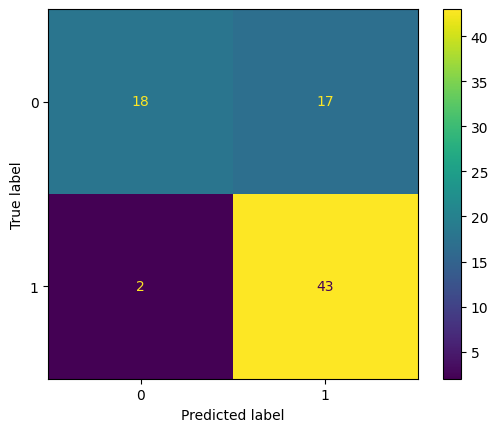

Validation:---------


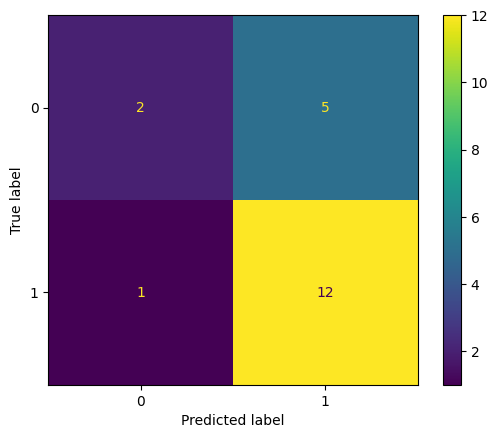

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
## Confusion matrix whose i-th row and j-th column entry
## indicates the number of samples with
## true label being i-th class and predicted label being j-th class.
## row -- true label; col -- pred label

print("Confusion_Matrix")
label = [0, 1]
print("Training:---------")
cm_train = confusion_matrix(y_train, y_train_, labels=label)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=label)
disp_train.plot()
plt.show()

print("Validation:---------")
cm_val = confusion_matrix(y_val, y_val_, labels=[0,1])
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=label)
disp_val.plot()
plt.show()

- Samples with true label `Y = 0` are easily being predicted as `Y_ = 1`

## ROC curve

On Training Set


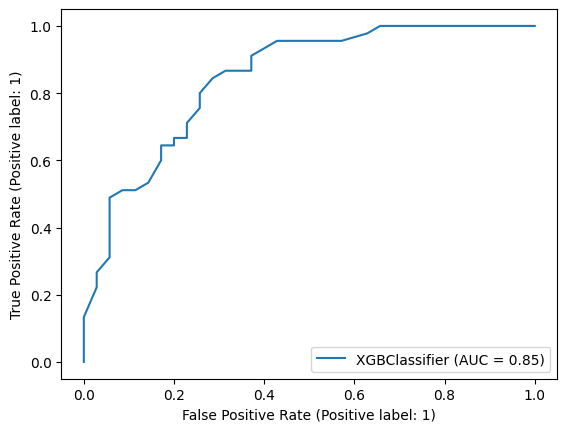

In [25]:
from sklearn.metrics import RocCurveDisplay

print("On Training Set")
RocCurveDisplay.from_estimator(clf_XGB, X_train, y_train)

On Validation Set: --------------


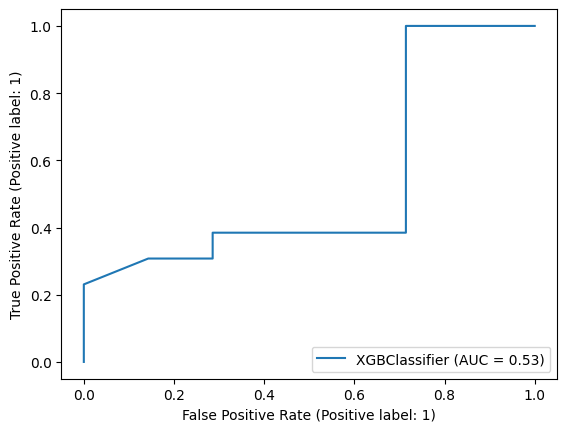

In [26]:
print("On Validation Set: --------------")
RocCurveDisplay.from_estimator(clf_XGB, X_val, y_val)

## Column Inspection

In [27]:
def show_val_avg_Y_and_X_occr(X, Y, Y_, X_value=[1,2,3,4,5], \
                                    show_plot=True, \
                                    Colors = ['Blue', 'red', 'Orange'], \
                                    Labels=['val X Occur', 'val true Y Avg', 'val pred Y avg'], \
                                    ):
  """
  Input should be dataframe columns
  """
  X_value = np.array(X_value)

  info_t = show_avg_Y_and_observation(X, Y, X_value=X_value, show_plot=False)
  info_p = show_avg_Y_and_observation(X, Y_,  X_value=X_value, show_plot=False)

  X_num = info_t['X_num']
  Y_avg = info_t['Y_avg']
  Y_p_avg = info_p['Y_avg']  ## predicted

  if show_plot:
    fig, ax1 = plt.subplots()

    ## plot X occurrences
    ax1.set_xlabel('X Value')
    ax1.set_ylabel('X Occurrences')

    bar1 = ax1.bar(X_value, X_num, label=Labels[0], color=Colors[0])
    ax1.bar_label(bar1, padding=3, color=Colors[0])

    ax1.tick_params(axis='y')

    ## plot Y average
    ax2 = ax1.twinx()  # share the x-axis, new y-axis
    ax2.set_ylabel('Average Y')

    width = 0.2

    line1 = ax2.plot(X_value, Y_avg, marker="x", label=Labels[1], color=Colors[1])
    for i, j in zip(X_value, Y_avg):
      j = round(j, 4)
      plt.text(i-width, j+0.04, str(j), color=Colors[1])

    line2 = ax2.plot(X_value, Y_p_avg, marker="x", label=Labels[2], color=Colors[2])
    for i, j in zip(X_value, Y_p_avg):
      j = round(j, 4)
      plt.text(i-width, j-0.05, str(j), color=Colors[2])

    ax2.tick_params(axis='y')
    ax2.set_ylim(-0.05, 1.05)

    ## Add legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(0.02,1.02,1,0.2), loc="lower left",ncol=3)

    plt.show()

  return {"X_num": X_num, "Y_avg": Y_avg, "Y_p_avg": Y_p_avg}

# show_val_avg_Y_and_X_occr(val['X1'], val['Y'], val['Y_'])

**Below, on the validation set, for each value of a feature X, we will use the number of its occurrence, mean true label, and mean predicted label to plot.**

**X1**

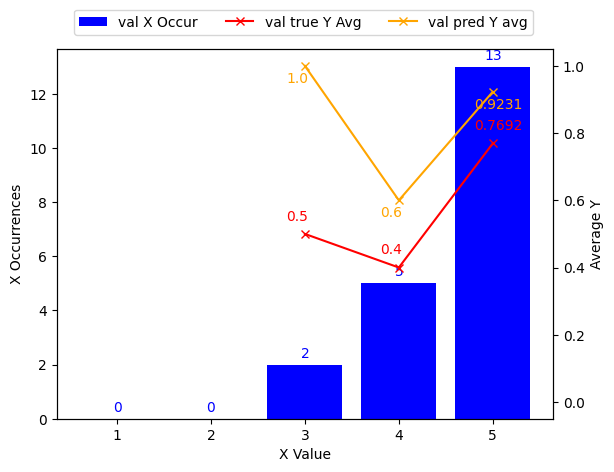

{'X_num': [0, 0, 2, 5, 13],
 'Y_avg': [nan, nan, 0.5, 0.4, 0.7692307692307693],
 'Y_p_avg': [nan, nan, 1.0, 0.6, 0.9230769230769231]}

In [28]:
show_val_avg_Y_and_X_occr(val['X1'], val['Y'], val['Y_'])

**X2**

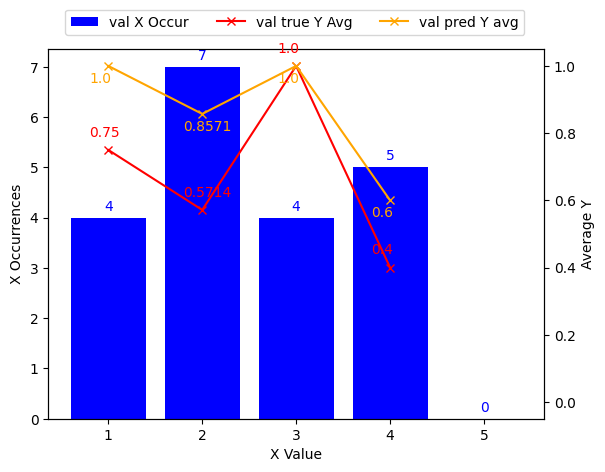

{'X_num': [4, 7, 4, 5, 0],
 'Y_avg': [0.75, 0.5714285714285714, 1.0, 0.4, nan],
 'Y_p_avg': [1.0, 0.8571428571428571, 1.0, 0.6, nan]}

In [29]:
show_val_avg_Y_and_X_occr(val['X2'], val['Y'], val['Y_'])

**X3**

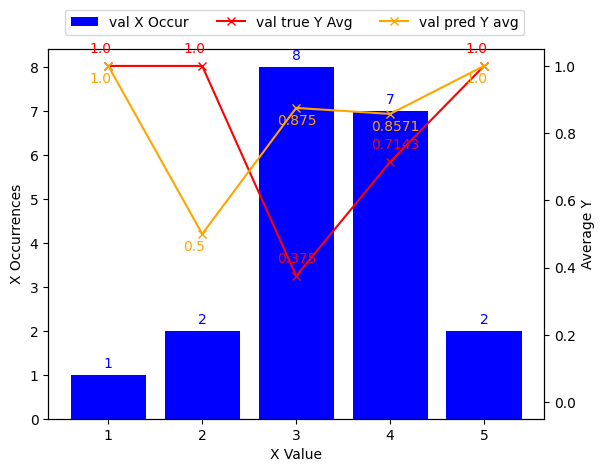

{'X_num': [1, 2, 8, 7, 2],
 'Y_avg': [1.0, 1.0, 0.375, 0.7142857142857143, 1.0],
 'Y_p_avg': [1.0, 0.5, 0.875, 0.8571428571428571, 1.0]}

In [30]:
show_val_avg_Y_and_X_occr(val['X3'], val['Y'], val['Y_'])

**X4**

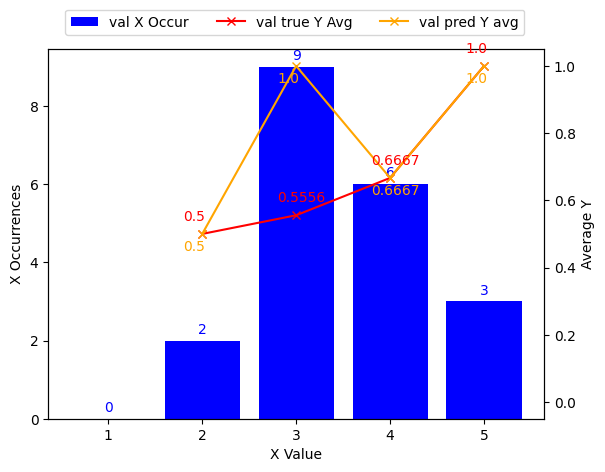

{'X_num': [0, 2, 9, 6, 3],
 'Y_avg': [nan, 0.5, 0.5555555555555556, 0.6666666666666666, 1.0],
 'Y_p_avg': [nan, 0.5, 1.0, 0.6666666666666666, 1.0]}

In [31]:
show_val_avg_Y_and_X_occr(val['X4'], val['Y'], val['Y_'])

**X5**

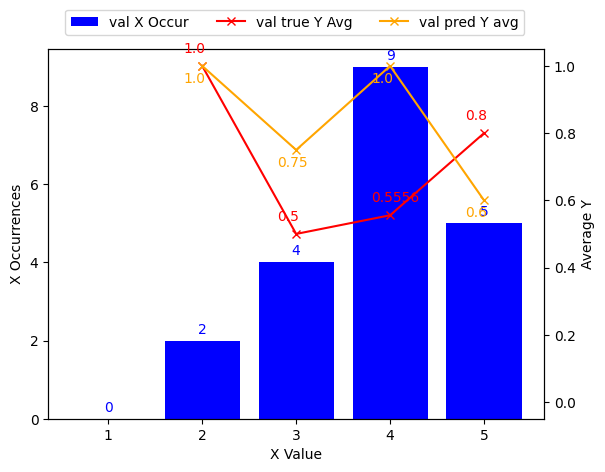

{'X_num': [0, 2, 4, 9, 5],
 'Y_avg': [nan, 1.0, 0.5, 0.5555555555555556, 0.8],
 'Y_p_avg': [nan, 1.0, 0.75, 1.0, 0.6]}

In [32]:
show_val_avg_Y_and_X_occr(val['X5'], val['Y'], val['Y_'])

**X6**

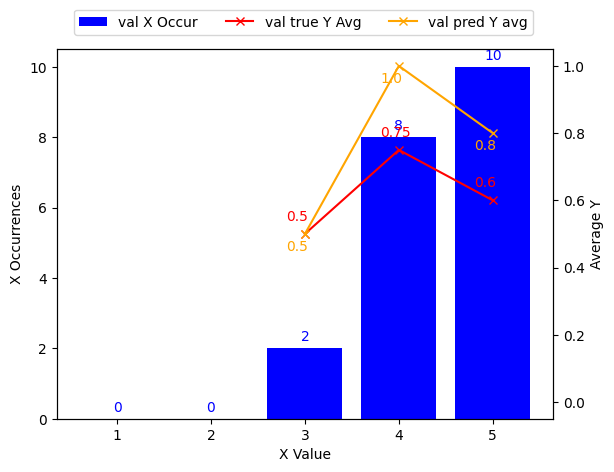

{'X_num': [0, 0, 2, 8, 10],
 'Y_avg': [nan, nan, 0.5, 0.75, 0.6],
 'Y_p_avg': [nan, nan, 0.5, 1.0, 0.8]}

In [33]:
show_val_avg_Y_and_X_occr(val['X6'], val['Y'], val['Y_'])

## Feature Importance

- usually by gini / entropy / info gain
- depending on the tree splitting `criteria`; the amount of impurity that was eliminated at each branch of the decision tree [[link]](https://www.codecademy.com/article/fe-feature-importance-final)
- by sklearn doc: computed as the mean and standard deviation of accumulation of the impurity decrease within each tree [[link]](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
- ! Not fully understand


**? By Gini Index:**

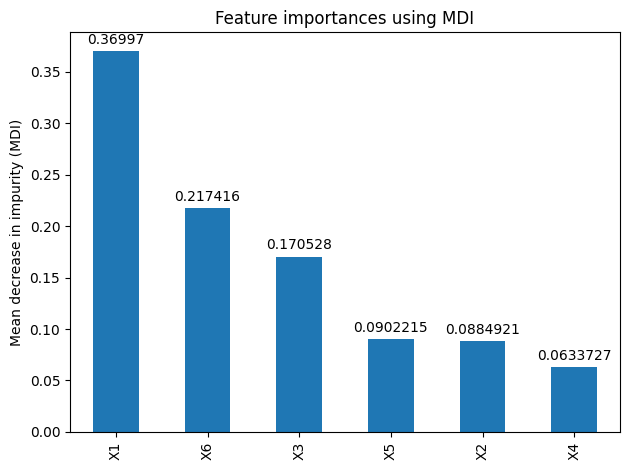

In [34]:
feature_names = X_train.columns

importances = clf_XGB.feature_importances_  ## ? using gini index by default (sklearn)
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots()
bar = forest_importances.plot.bar(ax=ax)
ax.bar_label(bar.containers[0], padding=3)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity (MDI)")
fig.tight_layout()

**By Info Gain:** [[Link]](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)

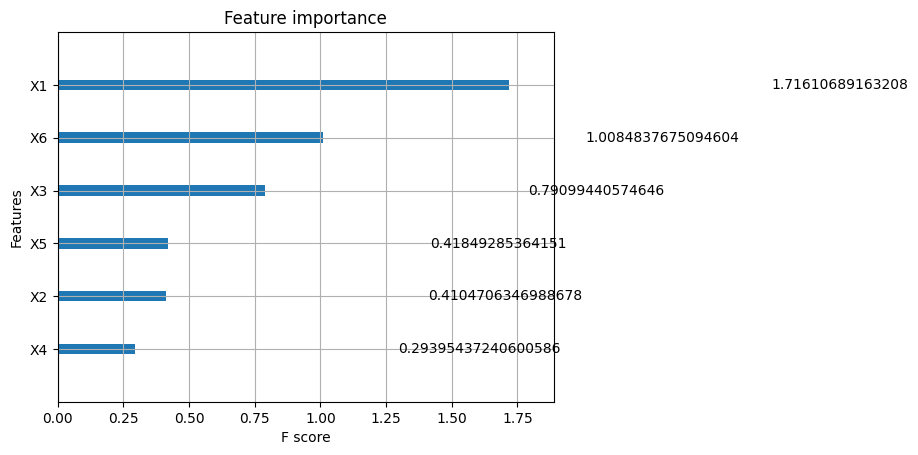

In [35]:
from xgboost import plot_importance

plot_importance(clf_XGB, importance_type='gain')  ## using info gain
plt.show()

- X4 and X2 may be deleted as they are the least important from the two plots above

# Exclude X4

- We find that drop X4 won't influence the model performance too much.

In [36]:
## drop X4
X_train_2 = X_train.drop(columns=['X4'])
X_val_2 = X_val.drop(columns=['X4'])
X_test_2 = X_test.drop(columns=['X4'])

## Train

In [37]:
clf_XGB2 = xgb.XGBClassifier(tree_method="hist", n_estimator=50, early_stopping_rounds=5)
clf_XGB2.fit(X_train_2, y_train, eval_set=[(X_val_2, y_val)])
print(f"training accuracy: {clf_XGB2.score(X_train_2, y_train)}")

print(f"validation accuracy: {clf_XGB2.score(X_val_2, y_val)}")

[0]	validation_0-logloss:0.64747
[1]	validation_0-logloss:0.64452
[2]	validation_0-logloss:0.65064
[3]	validation_0-logloss:0.65362
[4]	validation_0-logloss:0.64669
[5]	validation_0-logloss:0.63866
[6]	validation_0-logloss:0.64874
[7]	validation_0-logloss:0.66123
[8]	validation_0-logloss:0.66722
[9]	validation_0-logloss:0.67101
[10]	validation_0-logloss:0.68182
training accuracy: 0.7875
validation accuracy: 0.7


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:02:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


## Classification Report

In [38]:
y_val_2 = clf_XGB2.predict(X_val_2)
val['Y_2'] = y_val_2

print("Validation Report: ------------")
print(classification_report(y_val, y_val_2))

Validation Report: ------------
              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.71      0.92      0.80        13

    accuracy                           0.70        20
   macro avg       0.69      0.60      0.60        20
weighted avg       0.69      0.70      0.66        20



Confusion_Matrix
Validation:---------


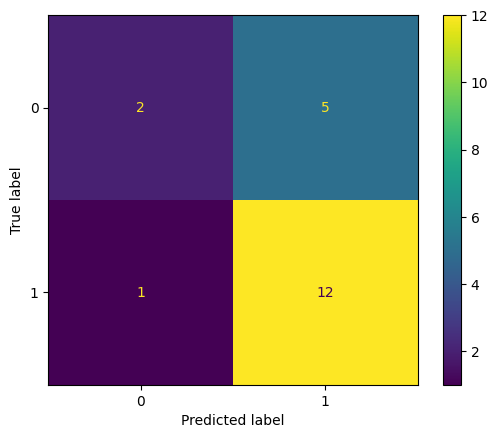

In [39]:
print("Confusion_Matrix")
label = [0, 1]
print("Validation:---------")
cm_val_2 = confusion_matrix(y_val, y_val_2, labels=label)
disp_val_2 = ConfusionMatrixDisplay(confusion_matrix=cm_val_2, display_labels=label)
disp_val_2.plot()
plt.show()

## ROC

On Validation Set: --------------


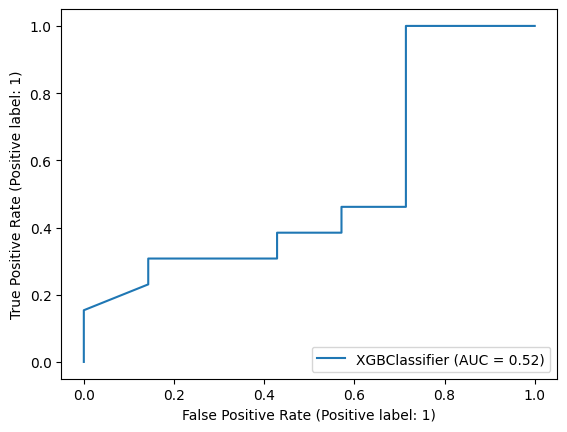

In [40]:
print("On Validation Set: --------------")
RocCurveDisplay.from_estimator(clf_XGB2, X_val_2, y_val)

# Test Set

- The two model have almost the same performance on validation set (except for the minor diff in the AUC of ROC).
- Hence, there's no obvious sign for which model to choose.
- In real case, we might choose the 2nd model `clf_XGB2` as it needs less data.
- Below we will test both of the two models on the test set as a final evaluation.

In [41]:
print(f"model 1 test accuracy: {clf_XGB.score(X_test, y_test)}")
print(f"model 2 test accuracy: {clf_XGB2.score(X_test_2, y_test)}")

model 1 test accuracy: 0.5384615384615384
model 2 test accuracy: 0.5384615384615384


## Classification Report

In [42]:
y_test_ = clf_XGB.predict(X_test)
test['Y_'] = y_test_

y_test_2 = clf_XGB2.predict(X_test_2)
test['Y_2'] = y_test_2

print("Test Report on Model 1: ------------")
print(classification_report(y_test, y_test_))

print("Test Report on Model 2: ------------")
print(classification_report(y_test, y_test_2))

Test Report on Model 1: ------------
              precision    recall  f1-score   support

           0       0.71      0.33      0.45        15
           1       0.47      0.82      0.60        11

    accuracy                           0.54        26
   macro avg       0.59      0.58      0.53        26
weighted avg       0.61      0.54      0.52        26

Test Report on Model 2: ------------
              precision    recall  f1-score   support

           0       0.71      0.33      0.45        15
           1       0.47      0.82      0.60        11

    accuracy                           0.54        26
   macro avg       0.59      0.58      0.53        26
weighted avg       0.61      0.54      0.52        26



# Conclusion

- The data itself is well prepared, not much preprocessing is needed
  - No missing value
  - Well structured -- same range    
  - However, the data size is very small

- We use XGBoost in this case (Model 1)
  - reason to use: ?
  - train accuracy: 0.7625    
    validatoin accuracy: 0.7

- Feature Selection
  - By two built-in feature importance methods
  - Drop X4 (Model 1)
  - No decrease in performace on val set

- Evaluation
  - Test set accuracy: 0.54

- Problem
  - Recall is very low. Samples that are labeled as 0 are often predicted as 1.
  - ...



# Future Improvement

- More Data
- Understand more about the detail of XGBoost, tune the model
- By searching in Github
  - [Example 1](https://github.com/VanshitaSharmaKumar/Apziva-Happy-Customers/blob/main/Happy%20Customers.ipynb)
    - Feature selection by [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) before training a model
    - Hyper param tuning by [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [Example 2](https://github.com/pravatiswain/Happy_customers_Apziva/blob/main/Happy%20Customers_%20Project1-%20Apziva.ipynb)
    - Use [Lazy Predict](https://pypi.org/project/lazypredict/) to first try on a large pool of modeling methods